# Sentimental Analysis - Phase 1

### Configure environment

In [2]:
from fabrictestbed_extensions.fablib.fablib import FablibManager as fablib_manager
fablib = fablib_manager() 
conf = fablib.show_config()

Credential Manager,cm.fabric-testbed.net
Orchestrator,orchestrator.fabric-testbed.net
Token File,/home/fabric/.tokens.json
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
Bastion Username,rjain116_0000108671
Bastion Private Key File,/home/fabric/work/fabric_config/fabric_bastion_key
Bastion Host,bastion.fabric-testbed.net
Bastion Private Key Passphrase,None
Slice Public Key File,/home/fabric/work/fabric_config/slice_key.pub
Slice Private Key File,/home/fabric/work/fabric_config/slice_key
Slice Private Key Passphrase,None


### Phase 1

### Define configuration for this experiment

In [3]:
slice_name = "singleThread" + fablib.get_bastion_username()

node_conf = [
    {'name': "source", 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['net-tools']},
    {'name': "pre-processing", 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['net-tools']},
    {'name': "tokenization", 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['net-tools']},
    {'name': "feature-extraction", 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['net-tools']},
    {'name': "destination", 'cores': 2, 'ram': 4, 'disk': 10, 'image': 'default_ubuntu_22', 'packages': ['net-tools']}
]

net_conf = [
    {"name": "net0", "subnet": "10.0.0.0/24",
     "nodes": [{"name": "source", "addr": "10.0.0.1"}, {"name": "pre-processing1", "addr": "10.0.0.2"}]},
    {"name": "net3", "subnet": "10.0.1.0/24",
     "nodes": [{"name": "pre-processing1", "addr": "10.0.1.1"}, {"name": "tokenization1", "addr": "10.0.1.2"}]},
    {"name": "net6", "subnet": "10.0.2.0/24",
     "nodes": [{"name": "tokenization1", "addr": "10.0.2.1"}, {"name": "feature-extraction1", "addr": "10.0.2.2"}]},
    {"name": "net9", "subnet": "10.0.3.0/24",
     "nodes": [{"name": "feature-extraction1", "addr": "10.0.3.1"}, {"name": "destination", "addr": "10.0.3.2"}]},
]

route_conf = [
    {"addr": "10.0.1.0/24", "gw": "10.0.0.2", "nodes": ["source"]},
    {"addr": "10.0.2.0/24", "gw": "10.0.1.2", "nodes": ["pre-processing1"]},
    {"addr": "10.0.3.0/24", "gw": "10.0.2.2", "nodes": ["tokenization1"]},
    {"addr": "10.0.4.0/24", "gw": "10.0.3.1", "nodes": ["feature-extraction1"]},
    {"addr": "10.0.5.0/24", "gw": "10.0.4.2", "nodes": ["destination"]},
]

exp_conf = {'cores': sum([n['cores'] for n in node_conf]), 'nic': sum([len(n['nodes']) for n in net_conf])}

### Reserve resources

Now, we are ready to reserve resources!

First, make sure you don’t already have a slice with this name:

In [4]:
try:
    slice = fablib.get_slice(slice_name)
    print("You already have a slice by this name!")
    print("If you previously reserved resources, skip to the 'log in to resources' section.")
except:
    print("You don't have a slice named %s yet." % slice_name)
    print("Continue to the next step to make one.")
    slice = fablib.new_slice(name=slice_name)

You already have a slice by this name!
If you previously reserved resources, skip to the 'log in to resources' section.


We will select a random site that has sufficient resources for our experiment:

In [28]:
while True:
    site_name = fablib.get_random_site()
    if ( (fablib.resources.get_core_available(site_name) > 1.2*exp_conf['cores']) and
        (fablib.resources.get_component_available(site_name, 'SharedNIC-ConnectX-6') > 1.2**exp_conf['nic']) ):
        break

fablib.show_site(site_name)

Name,KANS
State,Active
Address,"1100 Walnut Street,Kansas City,MO 64106"
Location,"(39.1002384, -94.582432)"
Hosts,3
CPUs,6
Cores Available,382
Cores Capacity,384
Cores Allocated,2
RAM Available,1504
RAM Capacity,1506


'<pandas.io.formats.style.Styler object at 0x7f8db7ba6a40>'

Then we will add hosts and network segments:

In [29]:
# this cell sets up the nodes
for n in node_conf:
    slice.add_node(name=n['name'], site=site_name, 
                   cores=n['cores'], 
                   ram=n['ram'], 
                   disk=n['disk'], 
                   image=n['image'])

In [30]:
# this cell sets up the network segments
for n in net_conf:
    ifaces = [slice.get_node(node["name"]).add_component(model="NIC_Basic", 
                                                 name=n["name"]).get_interfaces()[0] for node in n['nodes'] ]
    slice.add_l2network(name=n["name"], type='L2Bridge', interfaces=ifaces)

The following cell submits our request to the FABRIC site. The output of this cell will update automatically as the status of our request changes.

-   While it is being prepared, the “State” of the slice will appear as “Configuring”.
-   When it is ready, the “State” of the slice will change to “StableOK”.

You may prefer to walk away and come back in a few minutes (for simple slices) or a few tens of minutes (for more complicated slices with many resources).

In [ ]:
slice.submit()


Retry: 1, Time: 42 sec


ID,6ae316f1-b768-4e81-994c-5df2b5966cfe
Name,multiThreadrjain116_0000108671
Lease Expiration (UTC),2023-11-27 20:30:06 +0000
Lease Start (UTC),2023-11-26 20:30:07 +0000
Project ID,6ce270de-788d-4e07-8bae-3206860a6387
State,Configuring


ID,Name,Site,Type,State,Error
1b16d401-a7cb-42a2-87f4-ac182962cf7c,destination,KANS,node,Ticketed,
d2c468a3-47b6-425d-a3a0-a88bef1dde9e,feature-extraction1,KANS,node,Ticketed,
fc095d41-c411-448d-ad49-823891adee8e,feature-extraction2,KANS,node,Ticketed,
dca37745-b0f1-48b9-9f17-713a959545c4,feature-extraction3,KANS,node,Ticketed,
d0d1552c-b1a6-418f-83df-39c2635d75de,pre-processing1,KANS,node,Ticketed,
0822fa94-c2c9-45bf-8511-750a97061a33,pre-processing2,KANS,node,Ticketed,
5cdbe57d-12f8-4929-a73f-049a0ea042b1,pre-processing3,KANS,node,Ticketed,
66039824-0e8b-4aaf-b473-1067d9bfc08f,source,KANS,node,Ticketed,
b12c1fde-7c73-46f1-a558-7a74c045fb62,tokenization1,KANS,node,Ticketed,
85be39a2-e6a3-491e-8d0f-9e1a1a2fbcd2,tokenization2,KANS,node,Ticketed,


In [ ]:
slice.get_state()
slice.wait_ssh(progress=True)

### Configure resources

Next, we will configure the resources so they are ready to use.

In [6]:
slice = fablib.get_slice(name=slice_name)

In [ ]:
# install packages
# this will take a while and will run in background while you do other steps
for n in node_conf:
    if len(n['packages']):
        node = slice.get_node(n['name'])
        pkg = " ".join(n['packages'])
        node.execute_thread("sudo apt update; sudo apt -y install %s" % pkg)

In [ ]:
# bring interfaces up and either assign an address (if there is one) or flush address
from ipaddress import ip_address, IPv4Address, IPv4Network

for net in net_conf:
    for n in net['nodes']:
        if_name = n['name'] + '-' + net['name'] + '-p1'
        iface = slice.get_interface(if_name)
        iface.ip_link_up()
        if n['addr']:
            iface.ip_addr_add(addr=n['addr'], subnet=IPv4Network(net['subnet']))
        else:
            iface.get_node().execute("sudo ip addr flush dev %s"  % iface.get_device_name())

In [ ]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for n in slice.get_nodes():
    for h in hosts_txt:
        n.execute("echo %s | sudo tee -a /etc/hosts" % h)

In [ ]:
# enable IPv4 forwarding on all nodes
for n in slice.get_nodes():
    n.execute("sudo sysctl -w net.ipv4.ip_forward=1")

In [ ]:
# set up static routes
for rt in route_conf:
    for n in rt['nodes']:
        slice.get_node(name=n).ip_route_add(subnet=IPv4Network(rt['addr']), gateway=rt['gw'])

### Draw the network topology

The following cell will draw the network topology, for your reference. The interface name and addresses of each experiment interface will be shown on the drawing.

In [7]:
slice = fablib.get_slice(name=slice_name)

l2_nets = [(n.get_name(), {'color': 'lavender'}) for n in slice.get_l2networks() ]
l3_nets = [(n.get_name(), {'color': 'pink'}) for n in slice.get_l3networks() ]
hosts   =   [(n.get_name(), {'color': 'lightblue'}) for n in slice.get_nodes()]
nodes = l2_nets + l3_nets + hosts
ifaces = [iface.toDict() for iface in slice.get_interfaces()]
edges = [(iface['network'], iface['node'], 
          {'label': iface['physical_dev'] + '\n' + iface['ip_addr'] + '\n' + iface['mac']}) for iface in ifaces]

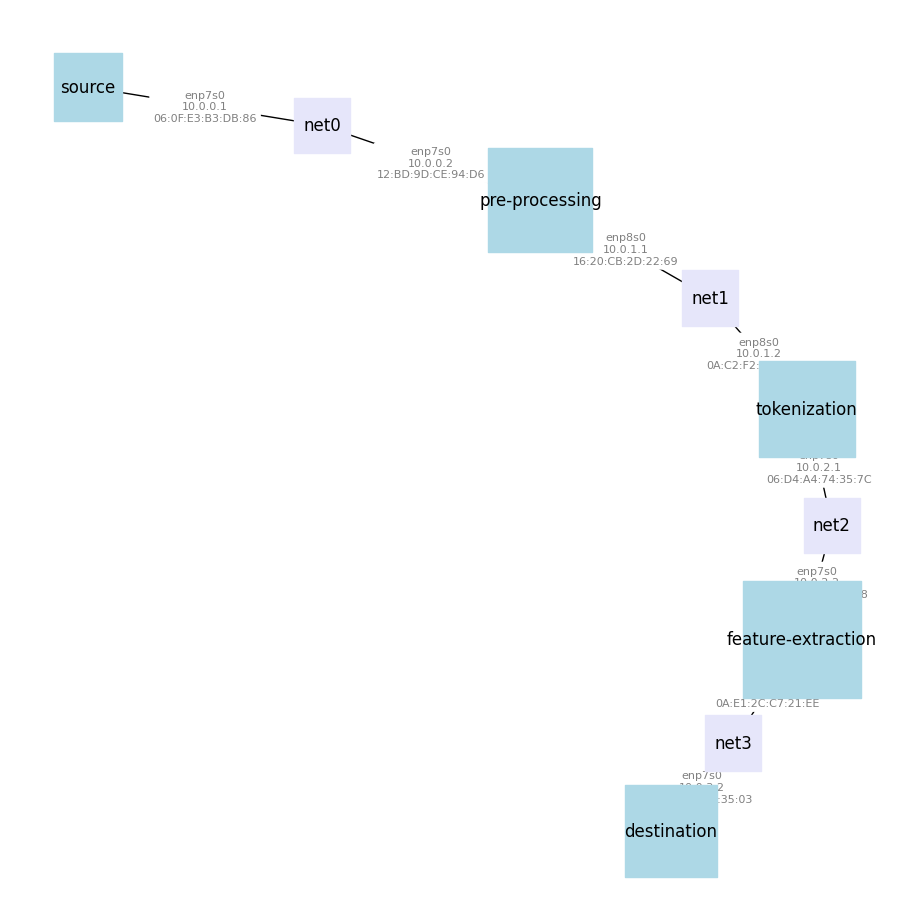

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Log into resources

Now, we are finally ready to log in to our resources over SSH! Run the following cells, and observe the table output - you will see an SSH command for each of the resources in your topology.

In [9]:
import pandas as pd

slice = fablib.get_slice(name="singleThread" + fablib.get_bastion_username())


pd.set_option('display.max_colwidth', None)
slice_info = [{'Name': n.get_name(), 'SSH command': n.get_ssh_command()} for n in slice.get_nodes()]
pd.DataFrame(slice_info).set_index('Name')

,SSH command
Name,
source,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3080:f816:3eff:fec2:49e6
pre-processing,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3080:f816:3eff:fe60:ffff
tokenization,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3080:f816:3eff:feb2:5a5a
feature-extraction,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3080:f816:3eff:fe1e:b104
destination,ssh -i /home/fabric/work/fabric_config/slice_key -F /home/fabric/work/fabric_config/ssh_config ubuntu@2001:400:a100:3080:f816:3eff:fede:b543


Now, you can open an SSH session on any of the resources as follows:

-   in Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   copy an SSH command from the table, and paste it into the terminal. (Note that each SSH command is a single line, even if the display wraps the text to a second line! When you copy and paste it, paste it all together.)

You can repeat this process (open several terminals) to start a session on each resource. Each terminal session will have a tab in the Jupyter environment, so that you can easily switch between them.

# File Transfer

The following code is responsible for transferring the required files to each node, where they can be executed for the experiment.

Before executing it, make sure to make a folder named "Project" in the home directory of the jupyter notebook and place the required files(you can find the required in the zip file in which this notebook was present) or you can update the path in the following code to the path to the required files if they are present at a different directory.

In [19]:
slice = fablib.get_slice(slice_name)

slice.get_node("source").upload_file("/home/fabric/work/Project/sender.py", "/home/ubuntu/sender.py")
slice.get_node("pre-processing").upload_file("/home/fabric/work/Project/receiveAndForward.py", "/home/ubuntu/receiveAndForward.py")
slice.get_node("tokenization").upload_file("/home/fabric/work/Project/receiveAndForward.py", "/home/ubuntu/receiveAndForward.py")
slice.get_node("feature-extraction").upload_file("/home/fabric/work/Project/receiveAndForward.py", "/home/ubuntu/receiveAndForward.py")
slice.get_node("destination").upload_file("/home/fabric/work/Project/receiveAndForward.py", "/home/ubuntu/receiveAndForward.py")

slice.get_node("feature-extraction").upload_file("/home/fabric/work/Project/sentiment_model.joblib", "/home/ubuntu/sentiment_model.joblib")
slice.get_node("feature-extraction").upload_file("/home/fabric/work/Project/tfidf_vectorizer.joblib", "/home/ubuntu/tfidf_vectorizer.joblib")


<SFTPAttributes: [ size=626 uid=1000 gid=1000 mode=0o100664 atime=1701107211 mtime=1701107211 ]>

# Execution

To execute the experiment, using the SSH commands, SSH into the nodes source, pre-processing, tokenization, feature-extraction and destination in different terminals. Now follow the below steps:
1. Execute command "sudo su" on terminal of all nodes.
2. Execute command "python3 ./receiveAndForward.py" on pre-processing, tokenization, feature-extraction and destination.
3. On sucessfull execution, you should see the line "Sniffing for Packets" on terminal of each node.
4. Now, execute "python3 ./sender.py" on source node. You should be seeing some output on the destination node.

# Results

After successfull execution of the above steps, you should be able to view the sentiment analysis of various data/sentences on the destination node.

The values on the destination node signifies the sentiment value of each sentence:

    1  -> Positive Sentence
    
    0  -> Neutral Sentence
    
    -1 -> Negative Sentence
    
In this Phase we wanted to establish the connections between the nodes and get accurate sentiment values at the destination efficiently.